In [1]:
import os
from pathlib import Path
import string

import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import autocrit

import utils.gfp
import utils.shared

In [2]:
plt.rcParams.update({'font.size': utils.shared.BASE_FONTSIZE})

In [3]:
def get_indices(point_df):
    
    critical_selector = point_df.critical
    flat_selector = point_df.flat
    
    critical_idx = point_df[critical_selector].sort_values("relres").index[0]

    flat_and_not_critical_idx = point_df[~critical_selector & flat_selector].sort_values("relres").index[-1]

    other_idx = point_df[~critical_selector & ~flat_selector]\
        .sort_values("relres").index[0]

    not_flat_and_critical_idx = point_df[critical_selector & ~flat_selector]\
        .sort_values("relres").index[0]
    
    return critical_idx, flat_and_not_critical_idx, other_idx

In [4]:
result_root = Path("..") / ".." / "results_win"
data_dir = result_root / "mnist_downsized"
network_dir = data_dir / "tuned_mlp"
optimizer_dir = network_dir / "momentum_optimizer"

In [5]:
cf_prefix_str = "newtonMR"
cfs = [elem for elem in os.listdir(optimizer_dir) if elem.startswith(cf_prefix_str)]

cf_output_paths = [(optimizer_dir / cf / "outputs") for cf in cfs]

trajs = utils.gfp.collect_trajs(cf_output_paths)

overall_traj_df = utils.gfp.make_overall_traj_df(trajs, maxiter=utils.gfp.maxiter)

mrqlp_df = utils.gfp.make_mrqlp_df(trajs, maxiter=utils.gfp.maxiter)

joined_df = overall_traj_df.merge(mrqlp_df, on=["traj_idx", "step_idx"])

max_flat_point_df = utils.gfp.make_max_flat_point_df(joined_df)

final_point_df = utils.gfp.make_final_point_df(joined_df)

In [6]:
final_point_df["flag"].value_counts(), max_flat_point_df["flag"].value_counts()

(2.0    60
 Name: flag, dtype: int64, 2.0    60
 Name: flag, dtype: int64)

In [7]:
final_point_df["flat"] = final_point_df["relres"] > utils.gfp.GFP_CUTOFF

final_point_df["critical"] = final_point_df["sgn"] < utils.gfp.SGN_CUTOFF

max_flat_point_df["flat"] = max_flat_point_df["relres"] > utils.gfp.GFP_CUTOFF

max_flat_point_df["critical"] = max_flat_point_df["sgn"] < utils.gfp.SGN_CUTOFF

In [8]:
final_point_df["critical"].mean(), max_flat_point_df["critical"].mean()

(0.1, 0.1)

In [9]:
final_point_df["flat"].mean(), max_flat_point_df["flat"].mean()

(0.06666666666666667, 0.9333333333333333)

In [10]:
critical_idx, flat_and_not_critical_idx, other_idx = get_indices(final_point_df)

In [11]:
data_npz = np.load(data_dir / "data.npz")
data = data_npz["xs"], data_npz["ys"]

network = autocrit.nn.networks.Network.from_json(
    data, network_dir / "network.json")

In [13]:
flat_eigval_dict = utils.gfp.get_eigval_dict(
    max_flat_point_df, trajs, "mlp_flat_lambdas.npz", network)

In [15]:
final_eigval_dict = utils.gfp.get_eigval_dict(
    final_point_df, trajs, "mlp_final_lambdas.npz", network)

In [16]:
flat_loss_index_pairs = np.array(
    utils.gfp.get_loss_index(flat_eigval_dict, trajs))
final_loss_index_pairs = np.array(
    utils.gfp.get_loss_index(final_eigval_dict, trajs))

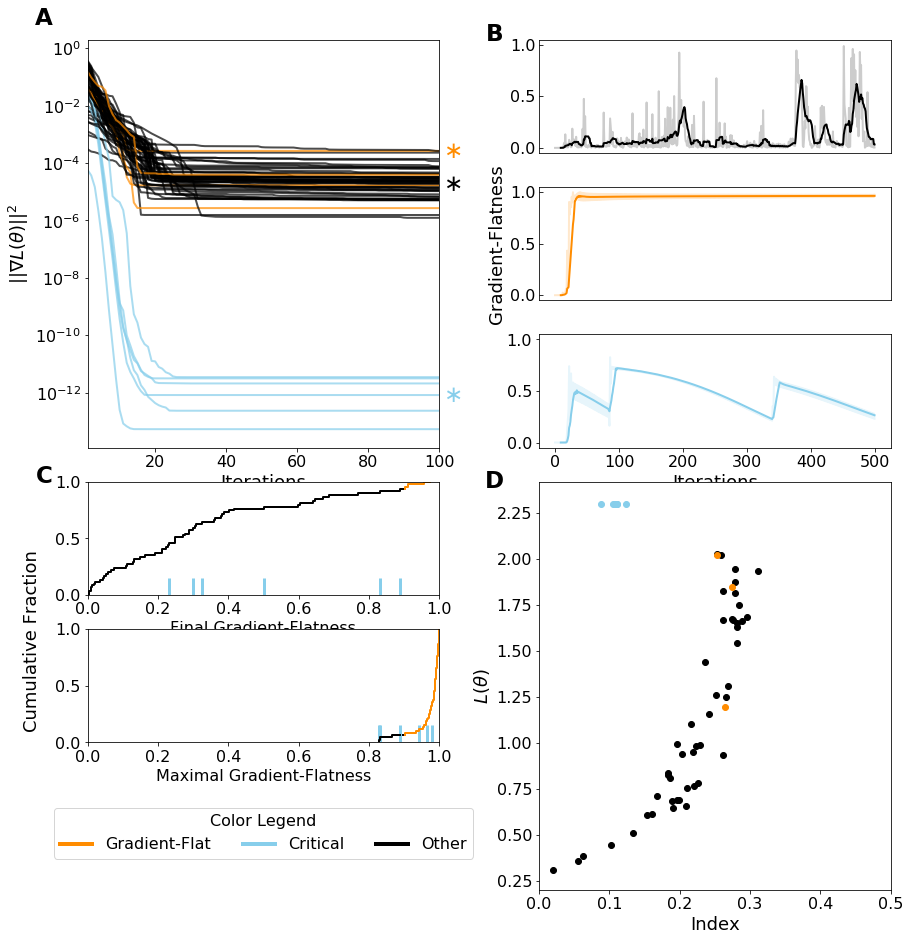

In [17]:
f, sgn_ax, relres_axs, ecdf_axs, loss_index_ax, legend_ax = utils.gfp.make_fig_and_axes()

idxs = [other_idx, flat_and_not_critical_idx, critical_idx]
colors = [utils.gfp.COLORS["other"], utils.gfp.COLORS["gfp"], utils.gfp.COLORS["cp"]]

utils.gfp.plot_compare_relres(joined_df, relres_axs, idxs, colors, rolling=10)
    
utils.gfp.plot_gradient_norms(joined_df, final_point_df, sgn_ax);
for idx, color in zip(idxs, colors):
    utils.gfp.sgn_annotate(sgn_ax, final_point_df, idx, color)
    
utils.gfp.plot_relres_ecdf(
    final_point_df, xlabel="Final Gradient-Flatness", ylabel="", ax=ecdf_axs[0]);
utils.gfp.plot_relres_ecdf(
    max_flat_point_df, xlabel="Maximal Gradient-Flatness", ylabel="", ax=ecdf_axs[1]);

utils.gfp.loss_index_scatter(final_loss_index_pairs, final_point_df, ax=loss_index_ax)

legend_ax.legend(*utils.gfp.color_legend_elements,
    ncol=3, title="Color Legend", loc="center")

f.text(s="Cumulative Fraction", x=0, y=0.32,
       fontdict={"rotation": "vertical", "va": "center", "size": utils.shared.LABEL_FONTSIZE})

plt.tight_layout(pad=-1.);

label_axs = [sgn_ax, relres_axs[0], ecdf_axs[0], loss_index_ax]
label_poss = [(-0.1, 1.08), (-0.1, 1.15), (-0.1, 1.15), (-0.1, 1.03)]

for label, ax, pos in zip(string.ascii_uppercase, label_axs, label_poss):
    utils.shared.add_panel_label(label, ax, pos=pos)

None

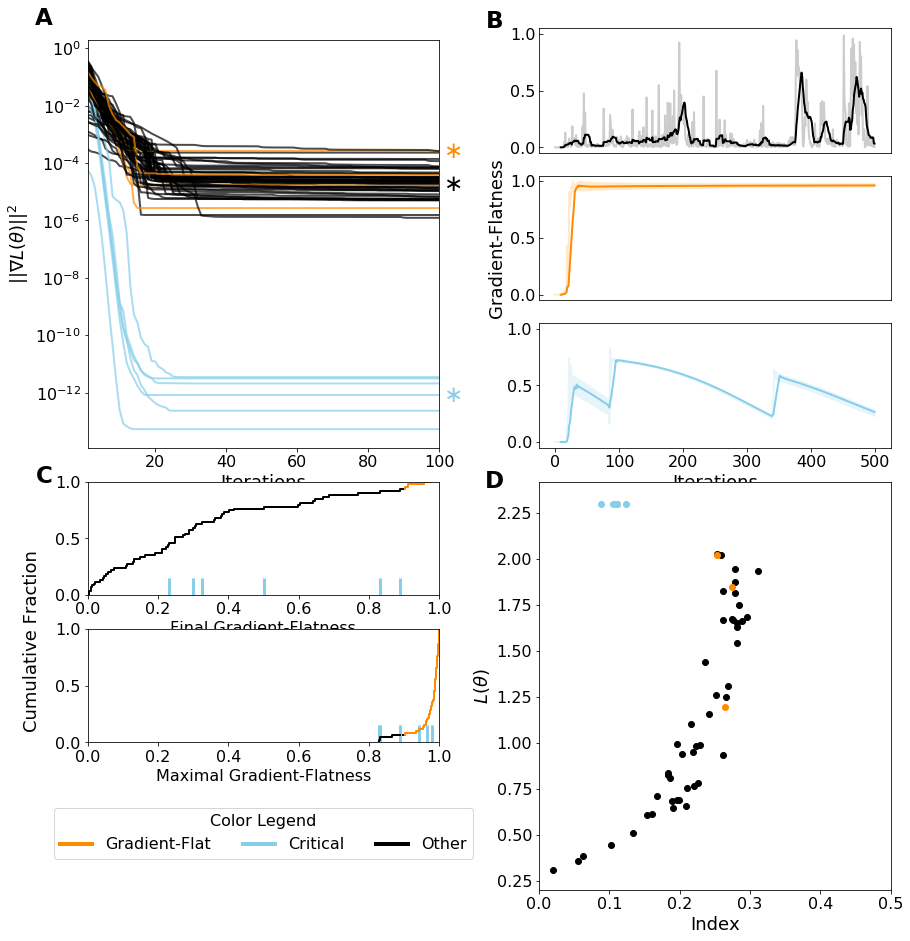

In [18]:
for ax in relres_axs:
    utils.shared.stretch(ax, y_stretch=1.1)
f

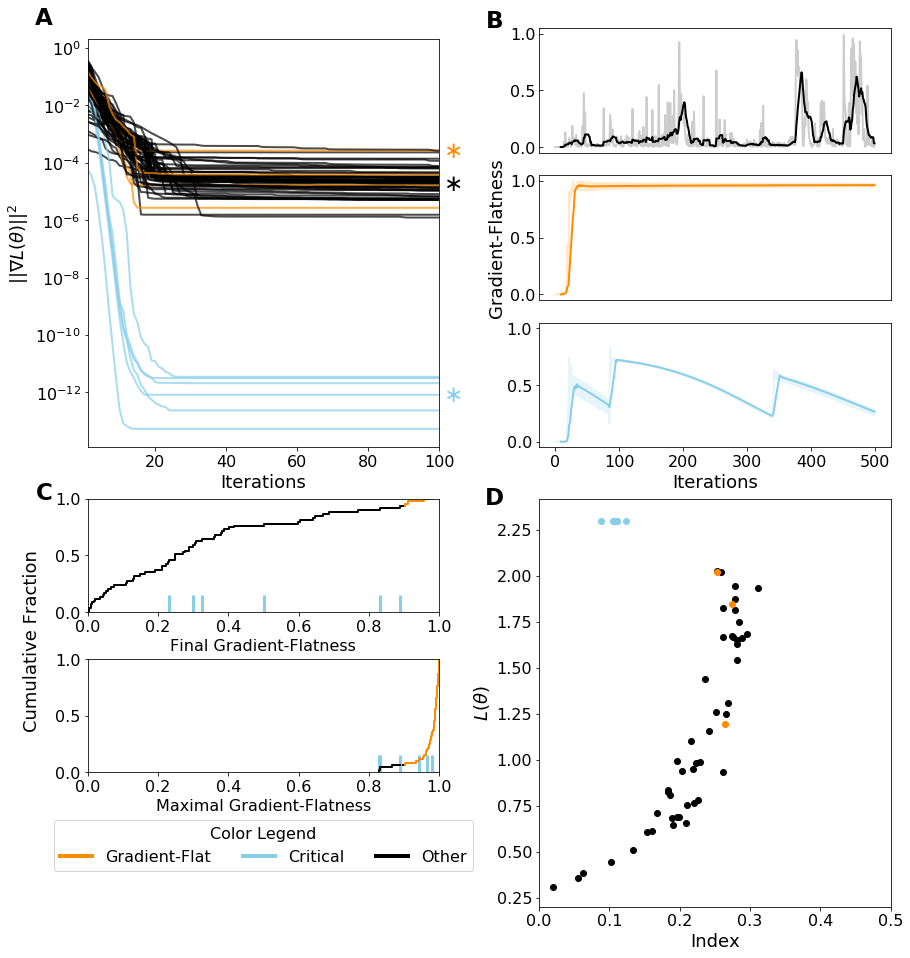

In [19]:
for ax in ecdf_axs + [loss_index_ax]:
    utils.shared.scooch(ax, y_scooch=-0.02)
    
for ax in [ecdf_axs[-1], legend_ax]:
    utils.shared.scooch(ax, y_scooch=-0.015)
f

In [22]:
for extension in ["svg", "pdf", "png"]:
    f.savefig(extension +"s" + "/fig_gfp_mlp." + extension, bbox_inches="tight")